# Connect-Four Game

Connect-four is a board game with a $6\times 7$ grid. Each player has $21$ checkers distinguished by black (B) and red (R) colors. The board is a vertical board and player can only drop their checkers from the top in any of the $7$ columns if the column is not full.

Each player alternate dropping a checker from the top until:

* A player makes a row, a column, or a diagonal set of $4$ checkers.
* No moves left and no sets are made by any player. This case is a draw.

We first set up a game which can be used for human-versus-human play. Then, we explain the Monte Carlo Tree Search (MCTS) algorithm and use it for human-versus-machine and machine-versus-machine plays.

In [357]:
import numpy as np
import matplotlib.pyplot as plt

In [358]:
players={1: "B", -1: "R", 0: "."}

def print_state(state):
    print("\n\t", end="")
    print("\n\t".join("  ".join([players[col] for col in row]) for row in state))
    print()

## Connect-Four Game Setup

We first set up a human-versus-human play. The algorithm calculates when a player wins or there's no move to make (draw) and terminates the game.

In [359]:
class Connect4(object):
    def __init__(self):
        # Grid shape.
        self.nrows = 6
        self.ncols = 7
        # number of connections to be made for winning.
        self.k = 4
        self.first_player = 1

    def __repr__(self):
        return self.__class__.__name__

    def init_state(self):
        return np.zeros((self.nrows, self.ncols), dtype=np.int8)

    def next_state(self, state, action, player):
        '''
        Returns the new state resulted by applying `action` taken by `player`
        on the current `state`.
        '''
        col = action
        row = np.argwhere(state[:, col] == 0)[-1][0]
        state[row, col] = player
        return state
    
    def available_actions(self, state):
        return np.where(state[0, :] == 0)[0]

    def opponent(self, player):
        return -player

    def opponent_reward(self, reward):
        return -reward
    
    def neutral_perspective(self, state, player):
        return player * state

    def won(self, state, action):
        '''
        Returns true if `action` taken resulted in a winnng `state`.
        '''
        if action is None:
            return False

        col = action
        # Find the first nonzero element in this column
        row = np.argwhere(state[:, col] != 0)[0][0]
        player = state[row, col]
        
        for i in range(self.nrows - self.k + 1):
            total = np.sum(state[i:i + self.k, col])
            if total == self.k * player:
                return True

        for j in range(self.ncols - self.k + 1):
            total = np.sum(state[row, j:j + self.k])
            if total == self.k * player:
                return True
                
        diag = np.diag(state, col - row)
        for j in range(len(diag) - self.k + 1):
            total = np.sum(diag[j:j + self.k])
            if total == self.k * player:
                return True

        flipped_col = self.ncols - col - 1
        diag = np.diag(np.fliplr(state), flipped_col - row)
        for j in range(len(diag) - self.k + 1):
            total = np.sum(diag[j:j + self.k])
            if total == self.k * player:
                return True
            
        return False

    def is_draw(self, state):
        return (np.sum(state[0, :] == 0) == 0)
    
    def is_over(self, state, action):
        return self.won(state, action) or self.is_draw(state)
    
    def reward(self, state):
        return 0 if self.is_draw(state) else 1

### Human-Human Play

In [31]:
c4 = Connect4()
player = c4.first_player
state = c4.init_state()

while True:
    print_state(state)
    print(f"player {players[player]} is to play...")
    
    available_actions = c4.available_actions(state)
    print(f"available actions: {c4.available_actions(state)}")
    
    if len(available_actions) == 0:
        print("draw!")
        break
    
    action = int(input("provide a valid move: "))
    state = c4.next_state(state, action, player)
    
    if c4.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
        
    player = c4.opponent(player)



	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  B  .  .
	.  .  .  .  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  R  .  .
	.  .  .  .  B  .  .
	.  .  .  .  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  . 

# Monte Carlo Tree Search

In this setion, we design a machine that can play against human or against another machine. We use Monte Carlo Tree Search (MCTS) to decide on the next move.

For a machine to be able to play against itself, we design it in a way that is agnostic of the player. We can assume that the player is always player 1, and change the perspective so that the machine acts as player -1. For calrification, consider the following state in a $6\times 7$ Connect-4 game:

$$
S = 
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & -1 & 1 & -1 & 0 & 0 & 0 \\
1 & 1 & 1 & -1 & -1 & 0 & 0
\end{pmatrix}
$$

Player -1 is to play. We can see this is equvalent to player 1 in state $-S$, where all elements are multiplied by $-1$. Thus, we can design MCTS algorithm which is player agnostic.

The MCTS algorithms is composed of four stages as follows:

1. Selection
2. Expansion
3. Simulation
4. Backpropagation

The input to the MCTS algorithm is the current state and the output is a probability distribution of all the possible moves. Based on the distribution, we can decide which action to take. This can be just the move with the highest probability.

<center>
<img src="./images/mcts-c4.png" width="800">
</center>

From the output of the MCTS algorithm, we choose the next action as $6$ since it has the highest probability and it's a winning move for Player 1.

The serarch tree is created as follows. We first create a root node with a given state. Then, we follow these steps:

1. Check if the current node is fully expanded or not. A node is fully expanded if it has children and no action can be taken.
2. If the node is fully expanded, we compute the Upper Confidence Bound (UCB) for each of its children and select the one with the highest UCB.
3. Continue the process until you reach a node which is not fully expanded.
4. Expand the node and move to the expanded node.
5. Run a simulation from the current node to determine if the player is won. Return the reward.
6. Run backpropagation to update the reward_sum and visit_count on all the nodes in the path from the node to the root.

This process is repeated for a set number of iteration. After that we look at the immediate children of the root node and compute the probability distribution of the visit_counts. We use this distribution to determine the next move.

<center>
<img src="./images/mcts-algorithm.png" width="500">
</center>

We use the following formula to compute the UCB of children nodes from a parent node to find out which child to select in the selection step.

$$
\frac{v_c}{n_c}+c\sqrt{\frac{\ln n_p}{n_c}},
$$

where 

* $n_p$ is the visit count of the parent node $P$,
* $n_c$ is the visit count of the child node $C$,
* $v_c$ is the total reward (number of wins minus number of losses),
* $c$ is the exploration factor.

<center>
<img src="./images/mcts-nodes.png" width="200">
</center>


In [10]:
params = {
    "exploration_factor": np.sqrt(2),
    "num_iters": 1000,
}

In [11]:
class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None):
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action
        
        self.children = []
        self.available_actions = (state[0, :] == 0).astype(np.int8)
        
        self.reward_sum = 0
        self.visit_count = 0
        
    def expected_reward(self, child):
        return -child.reward_sum / child.visit_count
        
    def ucb(self, child):
        '''
        Computes the Upper Confidence Bound (UCB).
        '''
        exploration_factor = self.params["exploration_factor"]
        exploration = np.sqrt(np.log(self.visit_count) / child.visit_count)
        return self.expected_reward(child) + exploration_factor * exploration   
    
    def is_fully_expanded(self):
        return len(self.children) > 0 and (np.sum(self.available_actions) == 0)
    
    def select(self):
        k = np.argmax([self.ucb(child) for child in self.children])
        return self.children[k]
    
    def expand(self):
        action = np.random.choice(np.where(self.available_actions == 1)[0])
        self.available_actions[action] = 0
        
        player = self.game.first_player
        other_player = self.game.opponent(player)
        
        child_state = self.game.next_state(self.state.copy(), action, player)
        child_state = self.game.neutral_perspective(child_state, other_player)
        
        child = Node(self.game, child_state, self.params, self, action)
        self.children.append(child)
        
        return child
    
    def simulate(self):
        state = self.state.copy()
        parent_action = self.parent_action
        player = self.game.first_player
        
        while not self.game.is_over(state, parent_action):
            parent_action = np.random.choice(np.where(state[0, :] == 0)[0])
            state = self.game.next_state(state, parent_action, player)
            player = self.game.opponent(player)
        
        reward = self.game.reward(state)
        # `player` took `parent_action` which resulted in winning `state` so the winner is the
        # other player and we need to rever reward.
        reward = self.game.opponent_reward(reward)
        return reward if player == self.game.first_player else self.game.opponent_reward(reward)
    
    def backward(self, reward):
        self.reward_sum += reward
        self.visit_count += 1
        
        reward = self.game.opponent_reward(reward)
        if self.parent is not None:
            self.parent.backward(reward)
    
class MCTS(object):
    def __init__(self, game, params):
        self.game = game
        self.params = params

    def best_policy(self, state):
        root = Node(self.game, state, self.params)
        num_iters = self.params["num_iters"]
        
        for _ in range(num_iters):
            node = self.find_node(root)
            reward = node.simulate()
            node.backward(reward)

        return self.compute_policy(root)
  
    def find_node(self, root):
        node = root

        while not self.game.is_over(node.state, node.parent_action):
            if not node.is_fully_expanded():
                return node.expand()
            node = node.select()   

        return node
    
    def compute_policy(self, node):
        out = np.zeros(self.game.ncols)
        for child in node.children:
            out[child.parent_action] = child.visit_count
        out /= np.sum(out)
        return out

## Human-Machine Play


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  .  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


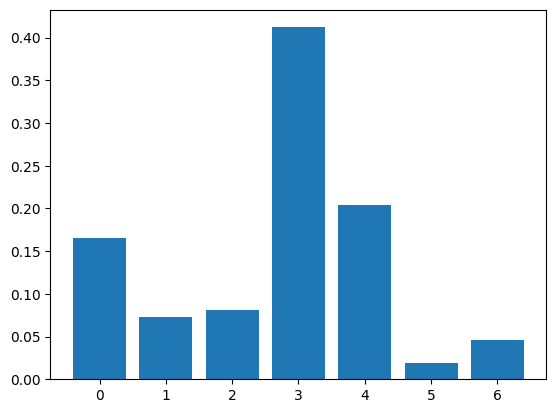


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  R  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  .  .  .  .
	B  .  .  R  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


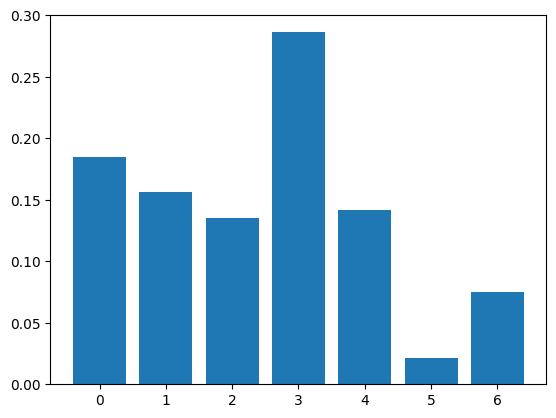


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  .  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


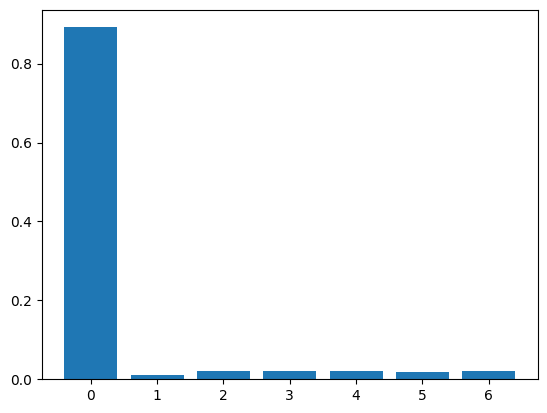


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  .  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


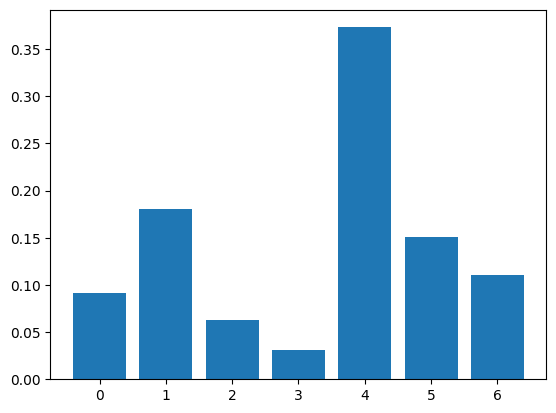


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  R  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


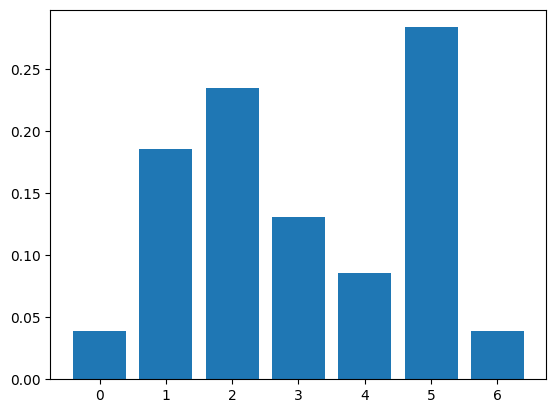


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  .  R  .
	B  .  .  R  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  B  R  .
	B  .  .  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


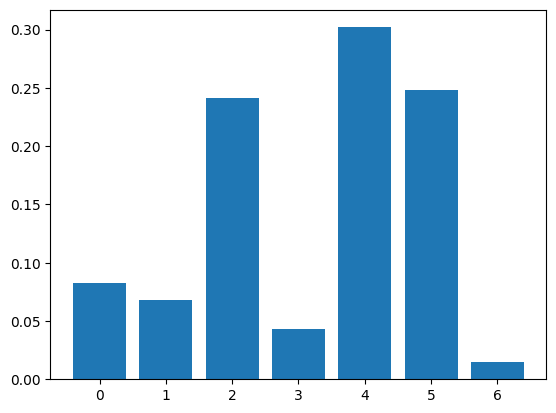


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  R  .  .
	B  .  .  R  B  R  .
	B  .  .  R  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  R  .  .
	B  .  .  R  B  R  .
	B  .  B  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


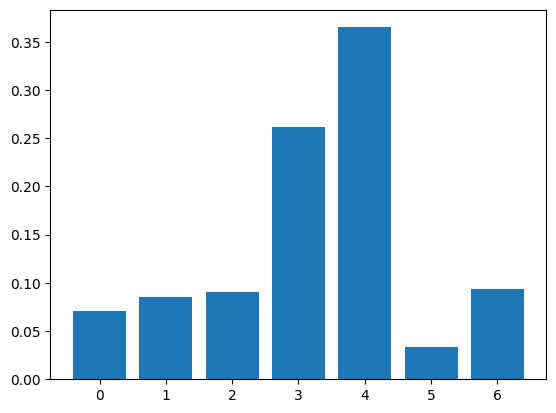


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  R  .  .
	B  .  .  B  R  .  .
	B  .  .  R  B  R  .
	B  .  B  R  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  R  .  .
	B  .  .  B  R  .  .
	B  .  B  R  B  R  .
	B  .  B  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


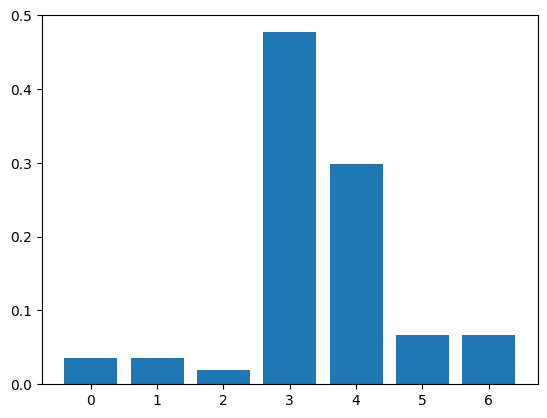


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  R  R  .  .
	B  .  .  B  R  .  .
	B  .  B  R  B  R  .
	B  .  B  R  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  R  R  .  .
	B  .  B  B  R  .  .
	B  .  B  R  B  R  .
	B  .  B  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


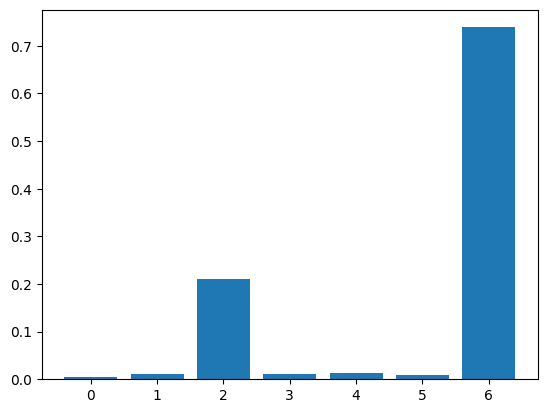


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  R  R  .  .
	B  .  B  B  R  .  .
	B  .  B  R  B  R  .
	B  .  B  R  R  B  R

player R won!


In [51]:
c4 = Connect4()
player = c4.first_player
state = c4.init_state()
mcts = MCTS(c4, params)

while True:
    print_state(state)
    print(f"player {players[player]} is to play...")
    
    available_actions = c4.available_actions(state)
    print(f"available actions: {c4.available_actions(state)}")
    
    if len(available_actions) == 0:
        print("draw!")
        break

    if player == c4.first_player:
        action = int(input("provide a valid move: "))
    else:
        neutral_state = c4.neutral_perspective(state, player)
        policy = mcts.best_policy(neutral_state)
        action = np.argmax(policy)        

        plt.bar(range(len(policy)), policy)
        plt.show()
    
    state = c4.next_state(state, action, player)

    if c4.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
        
    player = c4.opponent(player)
        

## Machine-Machine PLay


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]


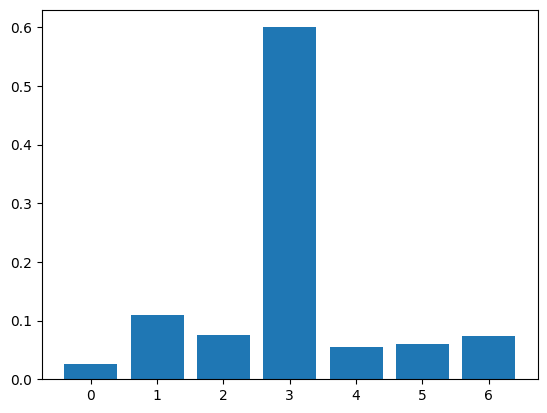


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  B  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


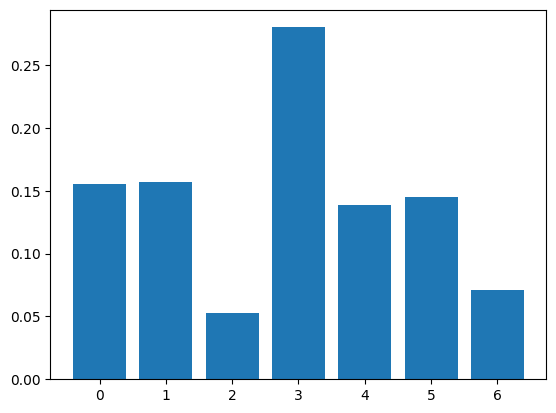


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  R  .  .  .
	.  .  .  B  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]


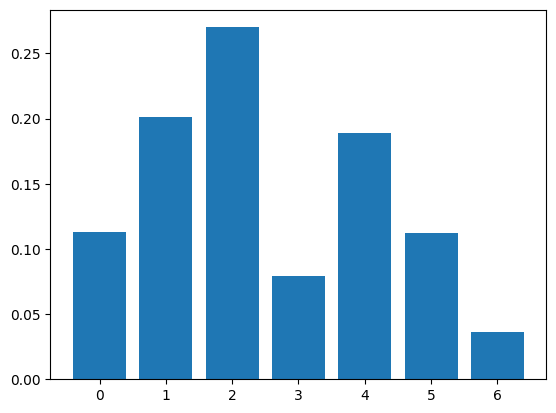


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  R  .  .  .
	.  .  B  B  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


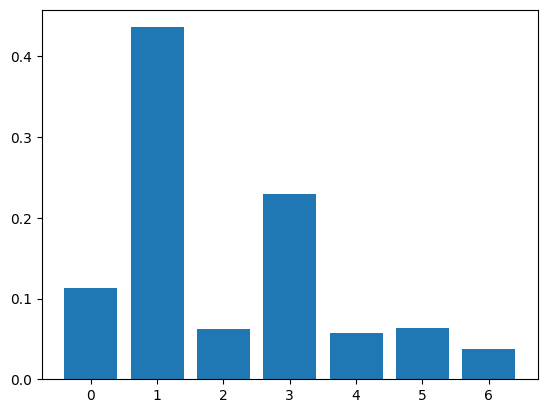


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  R  .  .  .
	.  R  B  B  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]


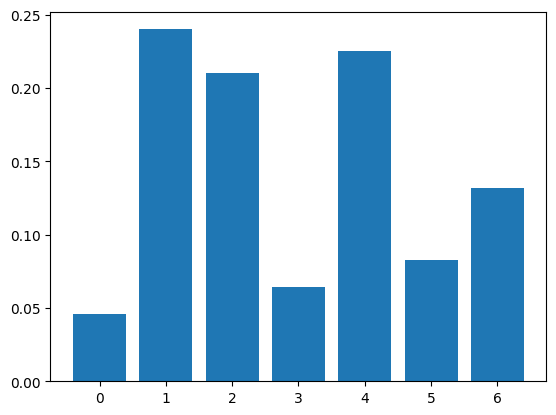


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  R  B  B  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


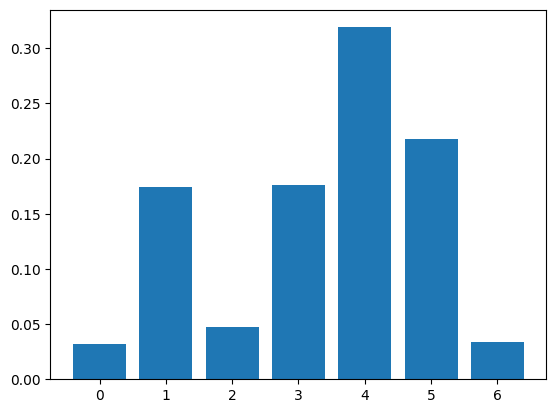


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  R  B  B  R  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]


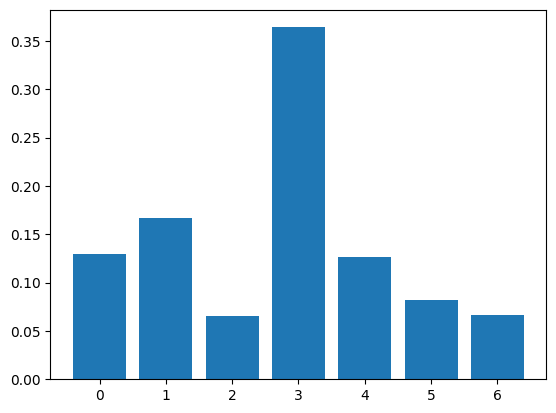


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  B  .  .  .
	.  B  .  R  .  .  .
	.  R  B  B  R  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


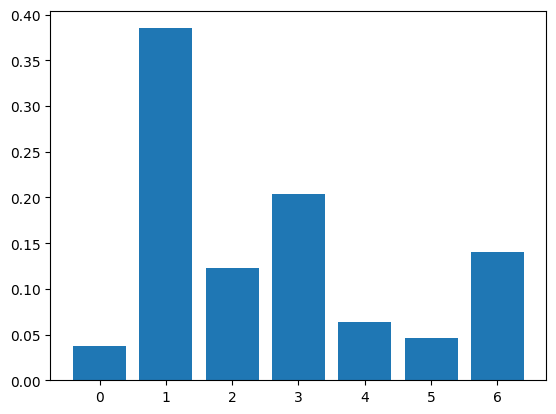


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  R  .  B  .  .  .
	.  B  .  R  .  .  .
	.  R  B  B  R  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]


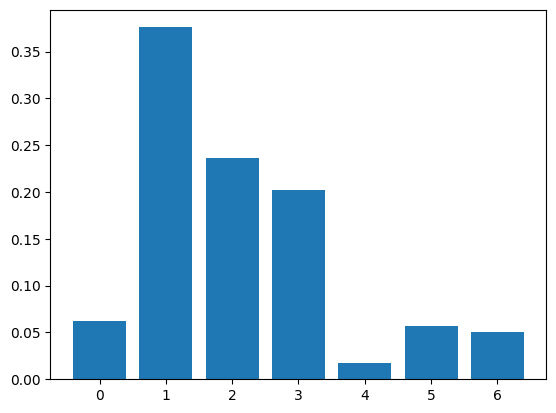


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  B  .  .  .  .  .
	.  R  .  B  .  .  .
	.  B  .  R  .  .  .
	.  R  B  B  R  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


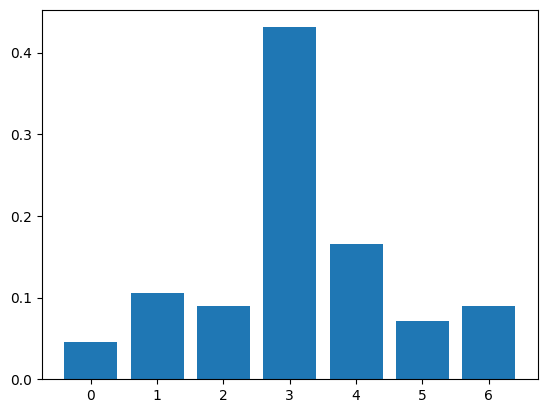


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  R  .  B  .  .  .
	.  B  .  R  .  .  .
	.  R  B  B  R  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]


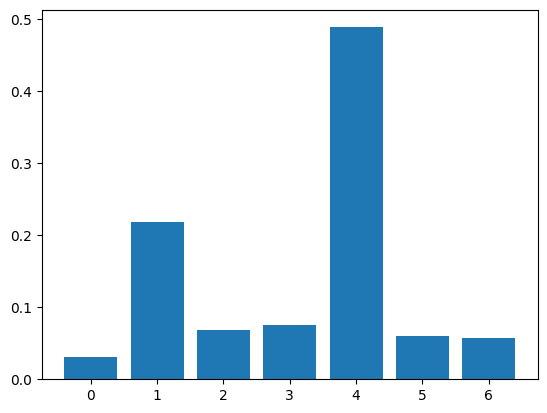


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  R  .  B  .  .  .
	.  B  .  R  B  .  .
	.  R  B  B  R  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


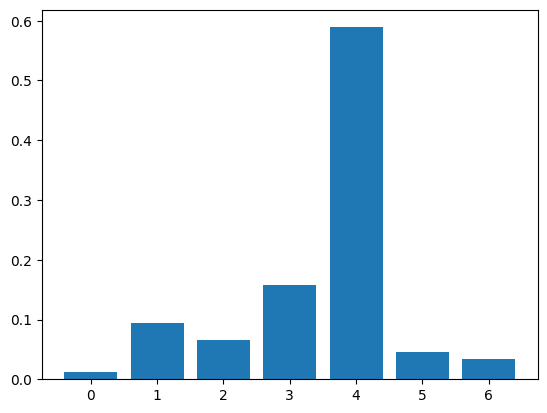


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  R  .  B  R  .  .
	.  B  .  R  B  .  .
	.  R  B  B  R  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]


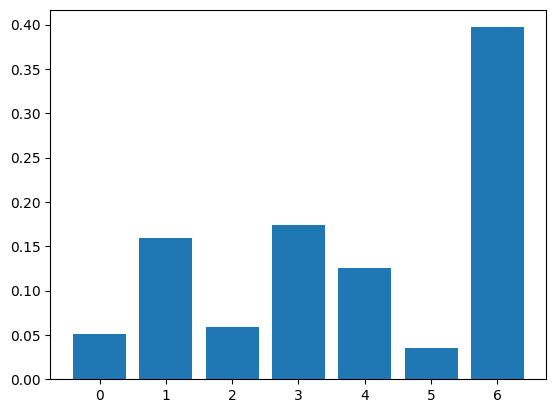


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  R  .  B  R  .  .
	.  B  .  R  B  .  .
	.  R  B  B  R  .  B

player R is to play...
available actions: [0 1 2 3 4 5 6]


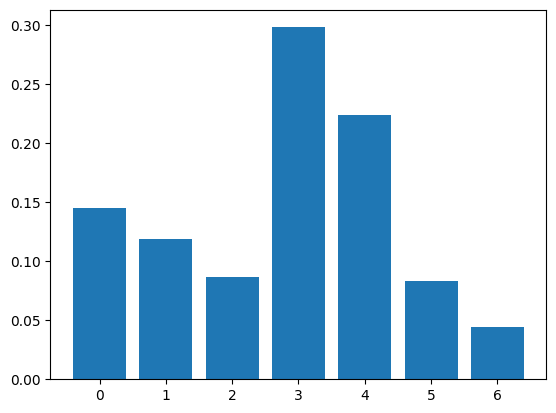


	.  .  .  .  .  .  .
	.  .  .  R  .  .  .
	.  B  .  R  .  .  .
	.  R  .  B  R  .  .
	.  B  .  R  B  .  .
	.  R  B  B  R  .  B

player B is to play...
available actions: [0 1 2 3 4 5 6]


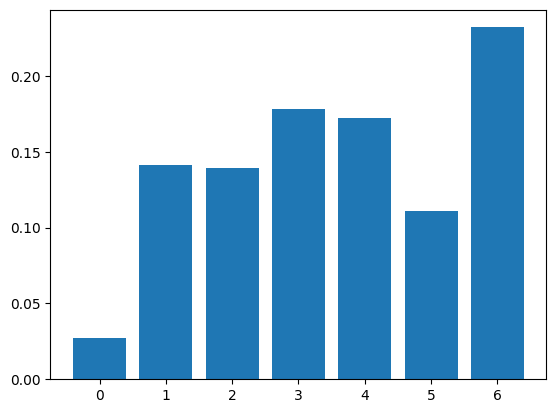


	.  .  .  .  .  .  .
	.  .  .  R  .  .  .
	.  B  .  R  .  .  .
	.  R  .  B  R  .  .
	.  B  .  R  B  .  B
	.  R  B  B  R  .  B

player R is to play...
available actions: [0 1 2 3 4 5 6]


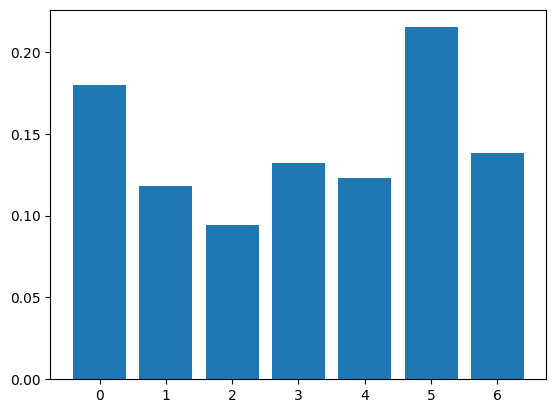


	.  .  .  .  .  .  .
	.  .  .  R  .  .  .
	.  B  .  R  .  .  .
	.  R  .  B  R  .  .
	.  B  .  R  B  .  B
	.  R  B  B  R  R  B

player B is to play...
available actions: [0 1 2 3 4 5 6]


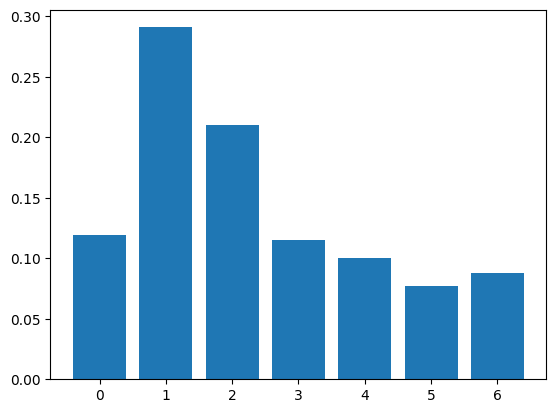


	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  B  .  R  .  .  .
	.  R  .  B  R  .  .
	.  B  .  R  B  .  B
	.  R  B  B  R  R  B

player R is to play...
available actions: [0 1 2 3 4 5 6]


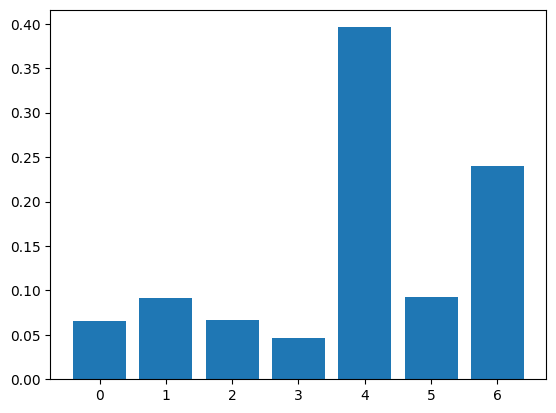


	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	.  B  .  R  B  .  B
	.  R  B  B  R  R  B

player B is to play...
available actions: [0 1 2 3 4 5 6]


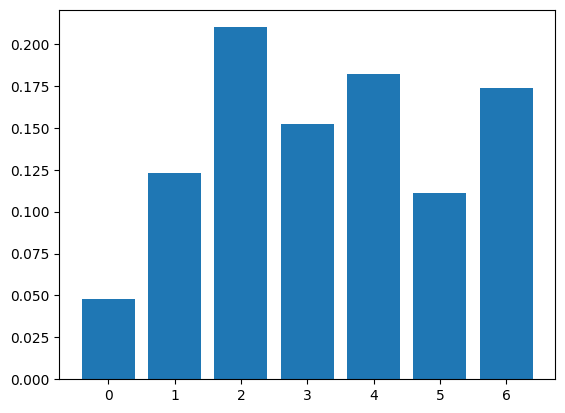


	.  .  .  .  .  .  .
	.  B  .  R  .  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	.  B  B  R  B  .  B
	.  R  B  B  R  R  B

player R is to play...
available actions: [0 1 2 3 4 5 6]


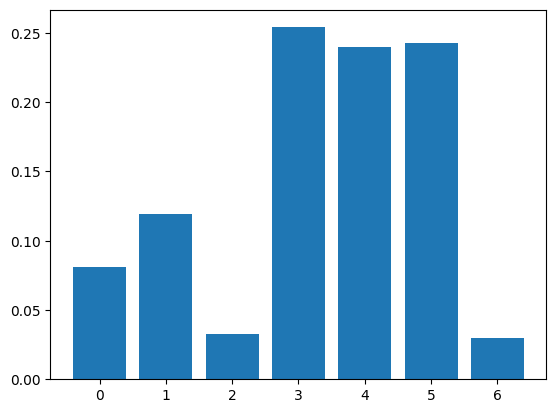


	.  .  .  R  .  .  .
	.  B  .  R  .  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	.  B  B  R  B  .  B
	.  R  B  B  R  R  B

player B is to play...
available actions: [0 1 2 4 5 6]


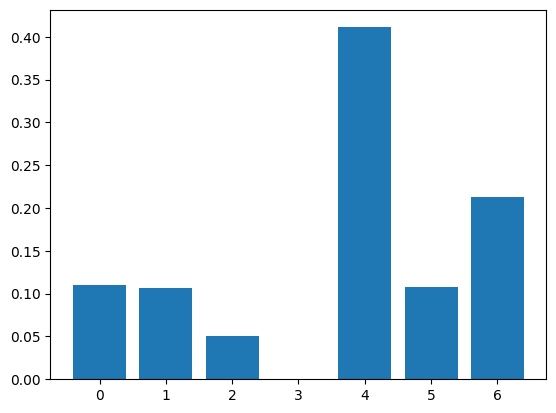


	.  .  .  R  .  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	.  B  B  R  B  .  B
	.  R  B  B  R  R  B

player R is to play...
available actions: [0 1 2 4 5 6]


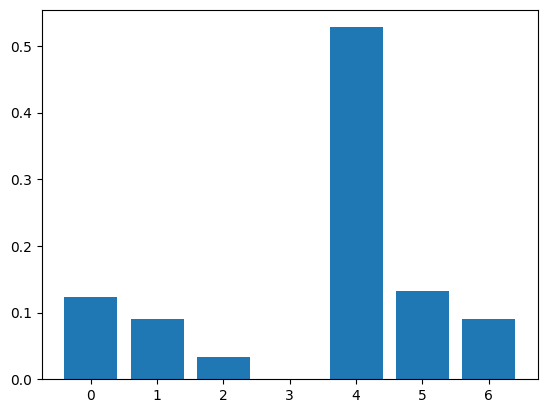


	.  .  .  R  R  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	.  B  B  R  B  .  B
	.  R  B  B  R  R  B

player B is to play...
available actions: [0 1 2 5 6]


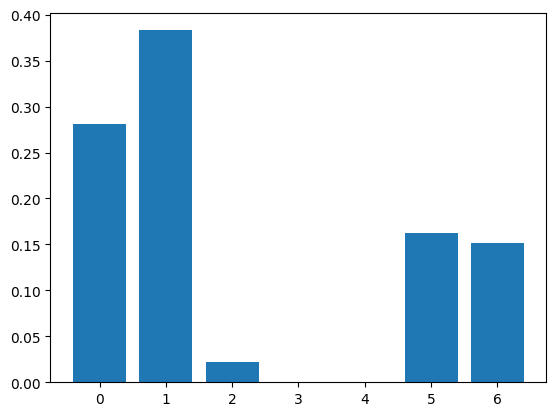


	.  B  .  R  R  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	.  B  B  R  B  .  B
	.  R  B  B  R  R  B

player R is to play...
available actions: [0 2 5 6]


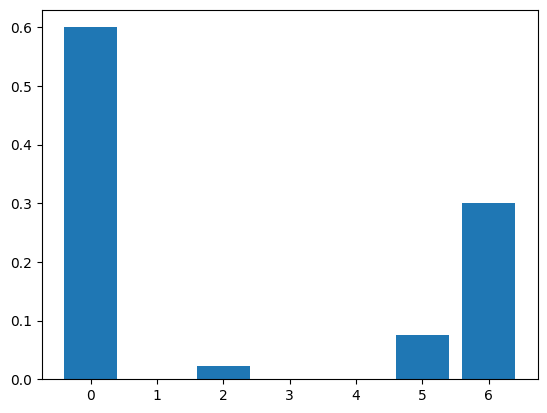


	.  B  .  R  R  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	.  B  B  R  B  .  B
	R  R  B  B  R  R  B

player B is to play...
available actions: [0 2 5 6]


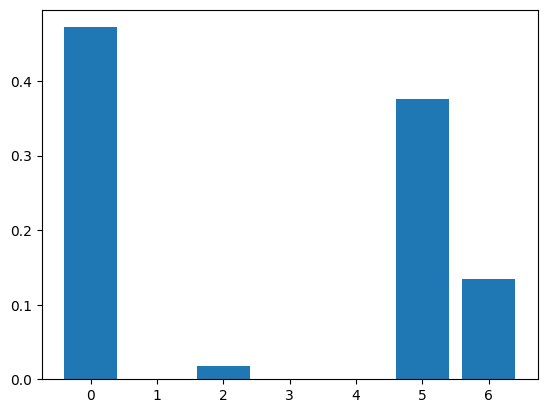


	.  B  .  R  R  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	B  B  B  R  B  .  B
	R  R  B  B  R  R  B

player R is to play...
available actions: [0 2 5 6]


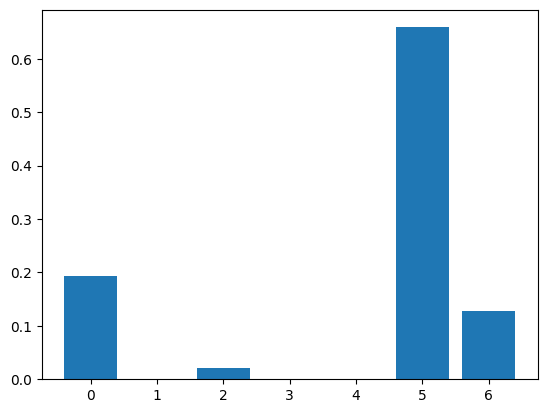


	.  B  .  R  R  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  .  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player B is to play...
available actions: [0 2 5 6]


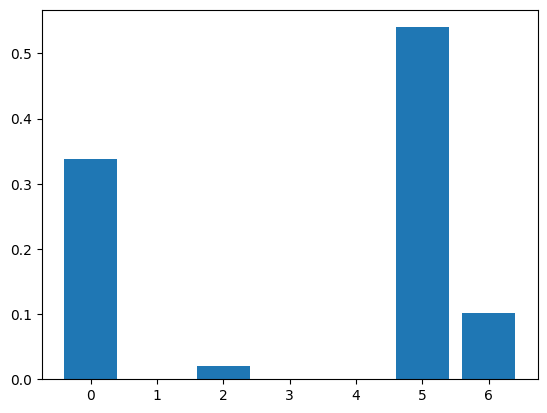


	.  B  .  R  R  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  .  .
	.  R  .  B  R  B  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player R is to play...
available actions: [0 2 5 6]


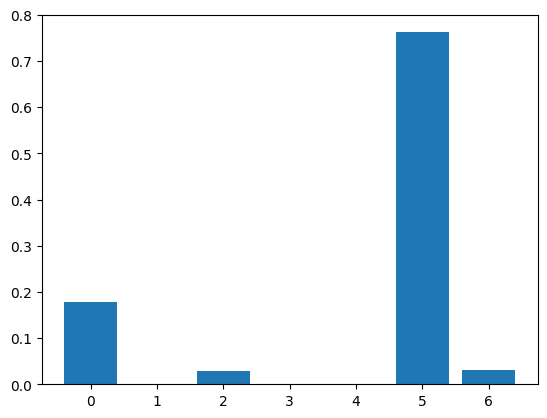


	.  B  .  R  R  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  R  .
	.  R  .  B  R  B  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player B is to play...
available actions: [0 2 5 6]


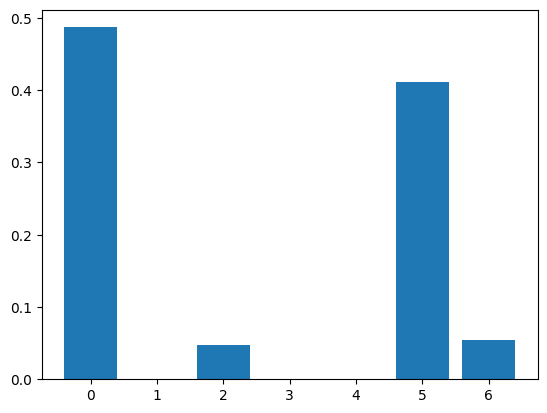


	.  B  .  R  R  .  .
	.  B  .  R  B  .  .
	.  B  .  R  R  R  .
	B  R  .  B  R  B  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player R is to play...
available actions: [0 2 5 6]


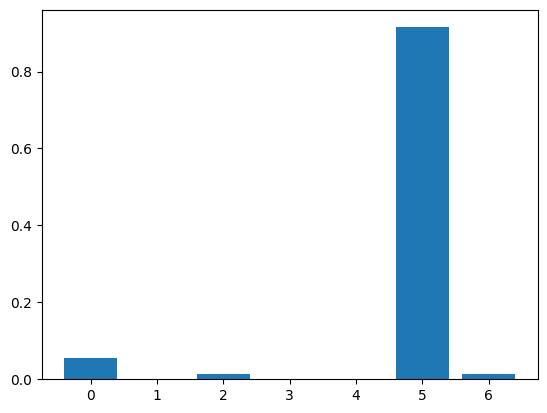


	.  B  .  R  R  .  .
	.  B  .  R  B  R  .
	.  B  .  R  R  R  .
	B  R  .  B  R  B  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player B is to play...
available actions: [0 2 5 6]


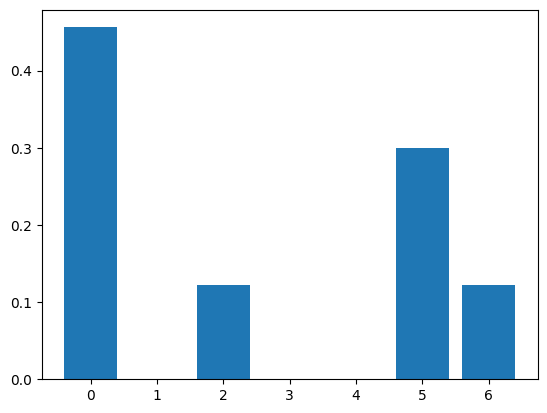


	.  B  .  R  R  .  .
	.  B  .  R  B  R  .
	B  B  .  R  R  R  .
	B  R  .  B  R  B  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player R is to play...
available actions: [0 2 5 6]


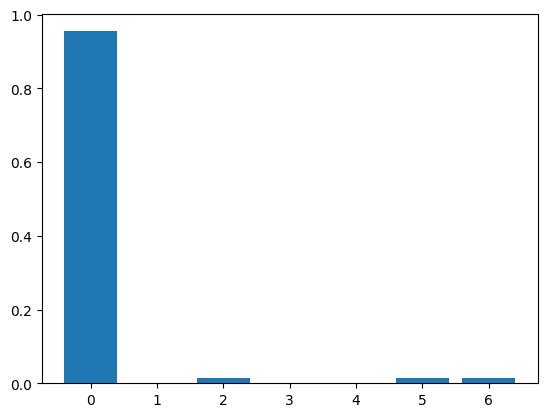


	.  B  .  R  R  .  .
	R  B  .  R  B  R  .
	B  B  .  R  R  R  .
	B  R  .  B  R  B  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player B is to play...
available actions: [0 2 5 6]


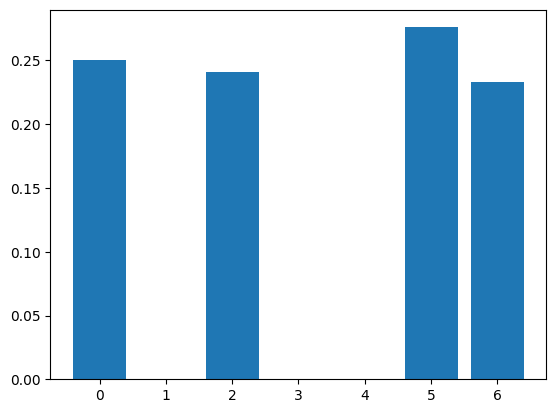


	.  B  .  R  R  B  .
	R  B  .  R  B  R  .
	B  B  .  R  R  R  .
	B  R  .  B  R  B  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player R is to play...
available actions: [0 2 6]


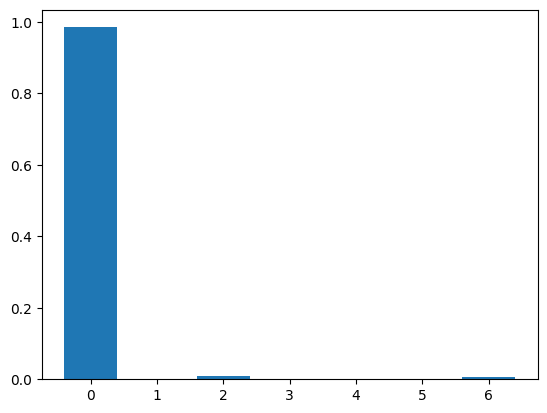


	R  B  .  R  R  B  .
	R  B  .  R  B  R  .
	B  B  .  R  R  R  .
	B  R  .  B  R  B  .
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player B is to play...
available actions: [2 6]


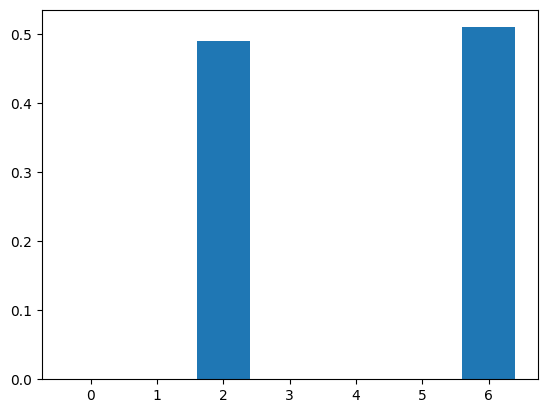


	R  B  .  R  R  B  .
	R  B  .  R  B  R  .
	B  B  .  R  R  R  .
	B  R  .  B  R  B  B
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player R is to play...
available actions: [2 6]


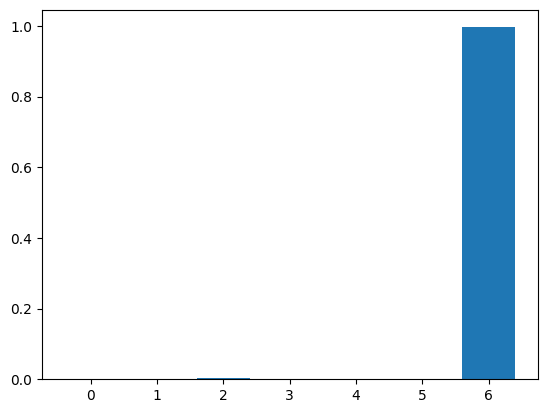


	R  B  .  R  R  B  .
	R  B  .  R  B  R  .
	B  B  .  R  R  R  R
	B  R  .  B  R  B  B
	B  B  B  R  B  R  B
	R  R  B  B  R  R  B

player R won!


In [52]:
c4 = Connect4()
player = c4.first_player
state = c4.init_state()
mcts = MCTS(c4, params)

while True:
    print_state(state)
    print(f"player {players[player]} is to play...")
    
    available_actions = c4.available_actions(state)
    print(f"available actions: {c4.available_actions(state)}")
    
    if len(available_actions) == 0:
        print("draw!")
        break

    neutral_state = c4.neutral_perspective(state, player)
    policy = mcts.best_policy(neutral_state)
    action = np.argmax(policy)        

    plt.bar(range(len(policy)), policy)
    plt.show()
    
    state = c4.next_state(state, action, player)

    if c4.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
        
    player = c4.opponent(player)
        

# MCTS with Neural Networks

In this approach, we build a convolutional neural network (CNN) to predict policy and reward given a state. To train such a model, we use MCTS with slight modifications. We remove the simulation step and use an untrained CNN. Like the simulation, the untrained model plays randomly to generate training data.

We modify the tree search by replacing the simulation step with a neural network which returns a policy and a reward for a given state. The serarch tree is created as follows. We first create a root node with a given state. Then, we follow these steps:

1. As long as the node has children, compute the Upper Confidence Bound (UCB) for each of its children and select the one with the highest UCB. Repeat this until you reach a leaf node.
2. Given the current node state, run a convolutional neural network (CNN) to get the policy and reward.
3. Fully expand this leaf node using the policy.
4. Using the reward, run the backpropagation to update the reward_sum and visit_count on all the nodes in the path from the node to the root.

This process is repeated for a set number of iteration. After that we look at the immediate children of the root node and compute the probability distribution of the visit_counts. We use this distribution to determine the next move.

Using this MCTS approach, we generate enough training and validation dataset for model training. Then, we train our CNN model. Once the model is trained it can be used for playing actual games.

<center>
<img src="./images/mcts-cnn-algorithm.png" width="500">
</center>

We use the following formula to compute the UCB of children nodes from a parent node to find out which child to select in the selection step.

$$
\frac{v_c}{n_c}+cp_c\frac{\sqrt{n_p}}{1 + n_c},
$$

where 

* $n_p$ is the visit count of the parent node $P$,
* $n_c$ is the visit count of the child node $C$,
* $v_c$ is the total reward (number of wins minus number of losses),
* $p_c$ is the prior probability provided by the policy from the CNN model for the child node state, 
* $c$ is the exploration factor.

## CNN Model

We build a CNN model that learns the following function which maps a state $S$ to a policy-reward pair $(P, R)$:

$$
f(S) = (P, R).
$$

The policy $P$ is a probability distribution of all possible next states from $S$ and $v$ is reward in $(-1, 1)$ which is interpreted as reward. Rewards close to $1$ indicates winning, while rewards close to $-1$ indicates losing. The rewards close to $0$ is interpreted as a drawish situation.

We interpret a state as an image in the CNN model. We use one-hot encoding for possible values $\{-1, 0, 1\}$ of each cell in a given state. So, let's define:

* $-1$: $[1, 0 ,0]$
* $\phantom{-}0$: $[0, 1 ,0]$
* $\phantom{-}1$: $[0, 0 ,1]$

As a result, we have a 3D input of size $3\times 6\times 7$ for a given state.

Then, we build multiple convolutional layers followed by two head as follows:

* **Policy Head:** The output layer size in this head is the number of possible next states. We apply softmax on the output layer to obtain a probability distribution which can be used to decide the next move.
* **Reward Head:** the output layer size in this head is one. We apply `Tanh` activation function to get a reward in $(-1, 1)$ representing a reward for the input state $S$. The reward is the model evaluation of a given state.

<center>
<img src="./images/connect4-cnn-model.png" width=800>
</center>

As we can see, we encode the current state and feed into the ResNet model which consists of multiple blocks arranged sequentially. A single block of the ResNet model consists of convolutional and batch normalization layers and ReLU activations as follows. Note that a skip connection is also added to the block.

<center>
<img src="./images/resnet-block.png" width=200>
</center>

In [360]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange

In [400]:
params = {
    "kernel_size": 3,
    "padding": 1,
    "embd_size": 3,
    "hidden_size": 128,
    "num_blocks": 8,
    "num_iters": 1000,
    "num_self_plays": 500,
    "num_threads": 100,
    "num_epochs": 10,
    "batch_size": 64,
    "exploration_factor": 2,
    "load_data": False,
    "load_model": False,
    "lr": 0.001,
    "weight_decay": 0.0001,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In the following, we build a convolutional neural network (CNN) which we descibed earlier.

In [362]:
class ResBlock(nn.Module):
    def __init__(self, hidden_size, params):
        super().__init__()

        kernel_size = params["kernel_size"]
        padding = params["padding"]
        
        self.res_block = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, kernel_size, padding=padding),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size, padding=padding),
            nn.BatchNorm2d(hidden_size)    
        )
    
    def forward(self, x):
        out = x + self.res_block(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, game, embd_size, hidden_size, num_blocks, params):
        super().__init__()
        
        kernel_size = params["kernel_size"]
        padding = params["padding"]

        self.start_block = nn.Sequential(
            nn.Conv2d(embd_size, hidden_size, kernel_size, padding=padding),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU()
        )
        
        self.res_blocks = nn.ModuleList(
            [ResBlock(hidden_size, params) for _ in range(num_blocks)]
        )
        
        self.policy_head = nn.Sequential(
            nn.Conv2d(hidden_size, embd_size, kernel_size, padding=padding),
            nn.BatchNorm2d(embd_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(embd_size * game.nrows * game.ncols, game.ncols)
        )
        
        self.reward_head = nn.Sequential(
            nn.Conv2d(hidden_size, embd_size, kernel_size, padding=padding),
            nn.BatchNorm2d(embd_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(embd_size * game.nrows * game.ncols, 1)            
        )  
    
    def forward(self, x):
        out = self.start_block(x)
        
        for res_block in self.res_blocks:
            out = res_block(out)
        
        logit = self.policy_head(out)
        reward = self.reward_head(out)
        
        return logit, reward

The following function encodes a $6\times 7$ state of a Connect4 game into a $3\times 6\times 7$ array, in which the first dimension if the embedding size.

In [363]:
def encode_state(state):
    '''
    m, n = state.shape
    output size: 3 x m x n
    '''
    return np.stack(
        [state == 1, state == 0, state == -1]
    ).astype(np.float32)

We now design an MCTS class which implements the tree search. Starting from a root node, the algorithm select a child if the current node is fully expanded. If not, the algorithm fully expands it to all possible states.

We replace the simulation part of the MCTS with an untrained CNN model. Thus, the algorithm plays randomly for a set number of iterations and records states, policies, and rewards as training dataset.

Using the training dataset from random plays, we will train a CNN model. The trained model can then be used for actual playing without a need for MCTS.

In [364]:
class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None, prior_prob=0):
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action
        
        self.children = []
        
        self.reward_sum = 0
        self.visit_count = 0
        self.prior_prob = prior_prob
        
    def expected_reward(self, child):
        if child.visit_count == 0:
            return 0
        return -child.reward_sum / child.visit_count
    
    def ucb(self, child):
        exploration_factor = self.params["exploration_factor"]
        exploration = np.sqrt(self.visit_count) / (1 + child.visit_count)
        return self.expected_reward(child) + exploration_factor * child.prior_prob * exploration
     
    def select(self):
        k = np.argmax([self.ucb(child) for child in self.children])
        return self.children[k]
    
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob == 0:
                continue
            
            player = self.game.first_player
            other_player = self.game.opponent(player)

            child_state = self.game.next_state(self.state.copy(), action, player)
            child_state = self.game.neutral_perspective(child_state, other_player)
            
            child = Node(self.game, child_state, self.params, self, action, prob)
            self.children.append(child)
            
    def backward(self, reward):
        self.reward_sum += reward
        self.visit_count += 1
        
        if self.parent is None:
            return

        reward = self.game.opponent_reward(reward)
        self.parent.backward(reward)

class MCTS(object):
    def __init__(self, game, model, params):
        self.game = game
        self.model = model
        self.params = params
    
    torch.no_grad()
    def best_policy(self, state):
        root = Node(self.game, state, self.params)
        num_iters = self.params["num_iters"]
        
        for _ in range(num_iters):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            if not self.game.is_over(node.state, node.parent_action):
                enc_state = encode_state(node.state)
                enc_state = torch.tensor(enc_state, device=self.params["device"]).unsqueeze(0)

                logit, reward = self.model(enc_state)
                reward = reward.item()
                # mask out illegal moves
                logit[:, node.state[0, :] != 0] = float("-inf")
                policy = F.softmax(logit, dim=1).squeeze(0).detach().cpu().numpy()
                
                node.expand(policy)
            else:
                reward = self.game.reward(node.state)
                reward = self.game.opponent_reward(reward)
                
            node.backward(reward)
            
        return self.compute_policy(root)
    
    def compute_policy(self, root):
        out = np.zeros(self.game.ncols)

        for child in root.children:
            out[child.parent_action] = child.visit_count

        out /= np.sum(out)
        return out

The following function generates multiple training dataset from a single play. The algorithm plays randomly against itself until a player wins or it's a draw.

As an example, suppose Player $1$ starts the game and Player $-1$ wins after $6$ moves. We record $\{(S_i, P_i, R_i)\mid i=0,\ldots,6\}$, where $S_i$ and $P_i$ are the state and policy at move $i$ and $R_i$ is the reward assigned for each move once the game is over. In this particular case, since Player $-1$ won after $6$ moves, we have:

$$
R = [-1, 1, -1, 1, -1, 1].
$$

We can repeat this generation process by many self-plays to generate more training and validation datasets.

In [365]:
def generate_data(mcts):
    c4 = mcts.game
    player = c4.first_player
    state = c4.init_state()

    reward = 0
    states, policies, players = [], [], []
    
    while True:
        available_actions = c4.available_actions(state)
        if len(available_actions) == 0:
            break
        
        players.append(player)
        
        neutral_state = c4.neutral_perspective(state, player)
        states.append(encode_state(neutral_state))

        policy = mcts.best_policy(neutral_state)
        policies.append(policy)
        
        action = np.random.choice(len(policy), p=policy)
        state = c4.next_state(state, action, player)
        
        if c4.won(state, action):
            reward = c4.reward(state)
            break
        
        player = c4.opponent(player)
        
    rewards = [reward if p == player else c4.opponent_reward(reward) for p in players]
    
    return states, policies, rewards
    
def generate_dataset(mcts, num_self_plays):
    states, policies, rewards = [], [], []
    
    for _ in trange(num_self_plays):
        s, p, r = generate_data(mcts)
        states.extend(s)
        policies.extend(p)
        rewards.extend(r)
        
    return np.array(states), np.array(policies), np.array(rewards)

To organize training and evaluation losses for the policy and reward, we define the following classes.

In [366]:
class Loss(object):
    def __init__(self):
        self.train = []
        self.eval = []

class Losses(object):
    def __init__(self):
        self.policy = Loss()
        self.reward = Loss()

We now define two functions for training and evaluating data. For a number of epochs, we feed in the encoded states in batches to the model to obtain predicted policies and rewards for the batch. We then compute the losses for both policies and rewards. We optimize model parameters to minimize both losses.

At every epoch, we also evaluate the updated model against the evaluation dataset. We save the model at certain checkpoints.

In [367]:
torch.no_grad()
def eval_model(model, eval_data, losses, params):
    device = params["device"]

    enc_states, target_policies, target_rewards = eval_data

    enc_states = torch.tensor(enc_states, dtype=torch.float32, device=device)
    target_policies = torch.tensor(target_policies, dtype=torch.float32, device=device)
    target_rewards = torch.tensor(target_rewards, dtype=torch.float32, device=device).unsqueeze(1)

    pred_logits, pred_rewards = model(enc_states)

    pred_policies = F.softmax(pred_logits, dim=1)
    policy_loss = F.cross_entropy(pred_policies, target_policies)
    reward_loss = F.mse_loss(pred_rewards, target_rewards)
    
    losses.policy.eval.append(policy_loss.item())
    losses.reward.eval.append(reward_loss.item())

def train_model(game, model, optimizer, train_data, eval_data, params, losses=None, num_models_to_save=1):
    if losses is None:
        losses = Losses()
    
    states, policies, rewards = train_data
    num_epochs = params["num_epochs"]
    batch_size = params["batch_size"]
    device = params["device"]
    
    for epoch in range(num_epochs):
        model.train()
        batch_indices = np.random.choice(len(states), batch_size)
        
        enc_states = torch.tensor(states[batch_indices], dtype=torch.float32, device=device)
        target_policies = torch.tensor(policies[batch_indices], dtype=torch.float32, device=device)
        target_rewards = torch.tensor(rewards[batch_indices], dtype=torch.float32, device=device).unsqueeze(1)
        
        pred_logits, pred_rewards = model(enc_states)

        pred_policies = F.softmax(pred_logits, dim=1)
        policy_loss = F.cross_entropy(pred_policies, target_policies)
        reward_loss = F.mse_loss(pred_rewards, target_rewards)
        
        losses.policy.train.append(policy_loss.item())
        losses.reward.train.append(reward_loss.item())
        
        optimizer.zero_grad(set_to_none=True)
        policy_loss.backward(retain_graph=True)
        reward_loss.backward()
        optimizer.step()
        
        if (epoch + 1) % (num_epochs/num_models_to_save) == 0:
            model_checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            torch.save(model_checkpoint, f"./models/{game}_{epoch+1}.pt")
        
        model.eval()
        eval_model(model, eval_data, losses, params)
        
    return losses


We are now ready to generate training and evaluation datasets. For this, we first create instances of the game, CNN model, and an MCTS.

In [368]:
c4 = Connect4()

embd_size = params["embd_size"]
hidden_size = params["hidden_size"]
num_blocks = params["num_blocks"]
model = ResNet(c4, embd_size, hidden_size, num_blocks, params)

mcts = MCTS(c4, model, params)

Then, we load the data from a checkpoint if we want to use an already saved data. Alternatively, we can generate new datasets.

In [369]:
load_data = params["load_data"]

if load_data:
    data_checkpoint = torch.load(f"./data/{c4}_data.pt")
    train_data = data_checkpoint["train_data"]
    eval_data = data_checkpoint["eval_data"]
else:
    num_self_plays = params["num_self_plays"]
    train_data = generate_dataset(mcts, num_self_plays)
    eval_data = generate_dataset(mcts, int(0.1 * num_self_plays))
    data_checkpoint = {
        "train_data": train_data,
        "eval_data": eval_data,
    }
    torch.save(data_checkpoint, f"./data/{c4}_data.pt")

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

We can now train a model using the dataset we generated.

In [370]:
losses = None

In [71]:
load_model = params["load_model"]
num_epochs = params["num_epochs"]
lr = params["lr"]
weight_decay = params["weight_decay"]

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if load_model:
    model_checkpoint = torch.load(f"./models/{c4}_{num_epochs}.pt")
    model = model_checkpoint["model"]
    optimizer = model_checkpoint["optimizer"]
else:
    num_models_to_save = 1
    losses = train_model(c4, model, optimizer, train_data, eval_data, params, losses, 
                num_models_to_save=num_models_to_save)

## Human-Machine Play

Let's now test the trained CNN model.

In [ ]:
c4 = Connect4()
state = c4.init_state()
player = c4.first_player

embd_size = params["embd_size"]
hidden_size = params["hidden_size"]
num_blocks = params["num_blocks"]
model = ResNet(c4, embd_size, hidden_size, num_blocks, params)

lr = params["lr"]
weight_decay = params["weight_decay"]
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

num_epochs = params["num_epochs"]
model_checkpoint = torch.load(f"./models/{c4}_{num_epochs}.pt")
model.load_state_dict(model_checkpoint["model"])
model.eval()
optimizer.load_state_dict(model_checkpoint["optimizer"])

while True:
    print_state(state)
    available_actions = c4.available_actions(state)
    
    if len(available_actions) == 0:
        print("draw!")
        break

    print(f"player {players[player]} to move...")
    print(f"available moves: ")

    if player == c4.first_player:
        action = int(input("provide your move: "))
    else:
        neutral_state = c4.neutral_perspective(state, player)
        enc_neutral_state = torch.tensor(encode_state(neutral_state), dtype=torch.float32).unsqueeze(0)

        logit, _ = model(enc_neutral_state)
        policy = F.softmax(logit, dim=1).squeeze(0).detach().cpu().numpy()
        action = np.argmax(policy)
        
        plt.bar(range(len(policy)), policy)
        plt.show()
    
    state = c4.next_state(state, action, player)
    
    if c4.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
    
    player = c4.opponent(player)

## Batch Processing

The MCTS class processes each state individualy resulting is a slow process of generating a training dataset. We can process states in batches to speed up the process.

First, we start with the encoding states. We generalize it as follows to encode the states in batches.

In [371]:
def encode_state_parallel(states):
    '''
    b, m, n = states.shape
    output size: 3 x b x m x n
    '''
    out = np.stack(
        [states == 1, states == 0, states == -1]
    ).astype(np.float32)
    out = np.swapaxes(out, 0, 1)
    return out

In [372]:
class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None, prior_prob=0):
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action
        
        self.children = []
        
        self.reward_sum = 0
        self.visit_count = 0
        self.prior_prob = prior_prob
        
    def ucb(self):
        '''
        Return a vector of UCBs of all children.
        '''
        children_visit_counts = np.array([child.visit_count for child in self.children])
        children_reward_sum = np.array([child.reward_sum for child in self.children])
        children_prior_probs = np.array([child.prior_prob for child in self.children])

        exploration_factor = self.params["exploration_factor"]
        exploration = np.sqrt(self.visit_count) / (1.0 + children_visit_counts)
        expected_reward = -np.divide(children_reward_sum, children_visit_counts,
                                     where=children_visit_counts!=0)
        
        return expected_reward + exploration_factor * children_prior_probs * exploration
     
    def select(self):
        k = np.argmax(self.ucb())
        return self.children[k]
    
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def create_child(self, action, prob):
        player = self.game.first_player
        other_player = self.game.opponent(player)

        child_state = self.game.next_state(self.state.copy(), action, player)
        child_state = self.game.neutral_perspective(child_state, other_player)
        
        child = Node(self.game, child_state, self.params, self, action, prob)
        return child
    
    def expand(self, policy):
        self.children = [self.create_child(a, p) for a, p in enumerate(policy) if p != 0]
            
    def backward(self, reward):
        node = self
        while node is not None:            
            node.reward_sum += reward
            node.visit_count += 1
            reward = self.game.opponent_reward(reward)
            node = node.parent

class MCTS(object):
    def __init__(self, game, model, params):
        self.game = game
        self.model = model
        self.params = params
        
    def select(self, node):
        while node.is_fully_expanded():
            node = node.select()
        return node
    
    torch.no_grad()
    def best_policies(self, states):
        roots = [Node(self.game, state, self.params) for state in states]
        num_iters = self.params["num_iters"]
        
        for _ in range(num_iters):
            batch_nodes = []
            for root in roots:
                node = self.select(root)

                if self.game.is_over(node.state, node.parent_action):
                    reward = self.game.reward(node.state)
                    reward = self.game.opponent_reward(reward)
                    node.backward(reward)
                else:
                    batch_nodes.append(node)
            
            if len(batch_nodes) == 0:
                continue

            batch_states = np.array([node.state for node in batch_nodes])
            enc_states = encode_state_parallel(batch_states)
            enc_states = torch.tensor(enc_states, device=self.params["device"])

            logits, rewards = self.model(enc_states)
            # mask out illegal moves
            logits[batch_states[:, 0, :] != 0] = -np.inf
            policies = F.softmax(logits, dim=1).detach().cpu().numpy()
            
            for node, policy, reward in zip(batch_nodes, policies, rewards):
                node.expand(policy)
                node.backward(reward.item())
        
        return self.compute_policies(roots)
    
    def compute_policies(self, roots):
        out = np.zeros((len(roots), self.game.ncols))

        for i, root in enumerate(roots):
            for child in root.children:
                out[i, child.parent_action] = child.visit_count

        out /= np.sum(out, axis=1, keepdims=True)
        return out

In [401]:
class ParallelPlay(object):
    def __init__(self, game):
        self.game = game
        self.current_state = game.init_state()
        self.states = []
        self.policies = []
        self.rewards = []
        self.players = []
        

def generate_data(mcts, num_threads):
    '''
    Runs `num_threads` games in parallel and generates data from all the states
    in all the games.
    outout: (states, policies, rewards)
    '''
    c4 = mcts.game
    player = c4.first_player
    par_plays = [ParallelPlay(c4) for _ in range(num_threads)]

    # storing all states, policies, and rewards from all the threads.
    out_states, out_policies, out_rewards = [], [], []
    
    while len(par_plays) > 0:
        states = np.array([p.current_state for p in par_plays])
        neutral_states = c4.neutral_perspective(states, player)
        policies = mcts.best_policies(neutral_states)
        
        for i in range(len(par_plays)-1, -1, -1):
            par_plays[i].states.append(neutral_states[i])
            par_plays[i].policies.append(policies[i])
            par_plays[i].players.append(player)

            action = np.random.choice(len(policies[i]), p=policies[i])
            state = c4.next_state(par_plays[i].current_state, action, player)
            
            if c4.is_over(state, action):
                out_states.extend(par_plays[i].states)
                out_policies.extend(par_plays[i].policies)

                reward = c4.reward(state)
                out_rewards.extend([reward if p == player else c4.opponent_reward(reward) for p in par_plays[i].players])

                del par_plays[i]                
        
        player = c4.opponent(player)
        
    return out_states, out_policies, out_rewards
    
def generate_dataset(mcts, num_self_plays, num_threads):
    states, policies, rewards = [], [], []
    
    for _ in trange(num_self_plays // num_threads):
        s, p, r = generate_data(mcts, num_threads)
        states.extend(s)
        policies.extend(p)
        rewards.extend(r)
        
    return np.array(states), np.array(policies), np.array(rewards)

In [402]:
c4 = Connect4()

embd_size = params["embd_size"]
hidden_size = params["hidden_size"]
num_blocks = params["num_blocks"]
model = ResNet(c4, embd_size, hidden_size, num_blocks, params)

mcts = MCTS(c4, model, params)

In [403]:
load_data = params["load_data"]
num_threads = params["num_threads"]

if load_data:
    data_checkpoint = torch.load(f"./data/{c4}_data.pt")
    train_data = data_checkpoint["train_data"]
    eval_data = data_checkpoint["eval_data"]
else:
    num_self_plays = params["num_self_plays"]
    %prun -T prun_1.txt train_data = generate_dataset(mcts, num_self_plays, num_threads)
    eval_data = generate_dataset(mcts, int(0.1 * num_self_plays), num_threads)
    data_checkpoint = {
        "train_data": train_data,
        "eval_data": eval_data,
    }
    torch.save(data_checkpoint, f"./data/{c4}_data.pt")

  0%|          | 0/5 [00:00<?, ?it/s]

# Draft

In [ ]:
s, p, r = train_data
print(s.shape, p.shape, r.shape)
k = 0
skip = False

while True:
    print_state(s[k])
    
    if np.sum(s[k] != 0) == 0 and skip:
        break

    skip = True
    
    plt.bar(range(len(p[k])), p[k])
    plt.show()
    
    print(r[k])
    k += 1